### Fig. 2HI: code to generate connectivity and cosine similarity matrices

In [11]:
# Import Libraries
from caveclient import CAVEclient
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.patches as mpatches

client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)

gray_map = sns.color_palette("blend:white,black", as_cmap=True)

In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    dend_dict = dendrogram(linkage_matrix, **kwargs)
    
    # sorted order of indices found through clustering
    clustered_order = dend_dict['ivl']
    plt.close()
    
    return clustered_order

In [2]:
# Specify the root_ids of the sensory neurons that we care about, put them into a list
FeCO_df= client.materialize.query_table('feco_axons_v0')
FeCO_df = FeCO_df[FeCO_df['classification_system'].str.contains('T1L')]
FeCO_df = FeCO_df.replace(to_replace='maybeclub', value='club')
FeCO_df = FeCO_df.replace(to_replace='club_asc', value='club')

hook_ids = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['pt_root_id'].to_list()
hook_types = FeCO_df[FeCO_df['cell_type'].str.contains('hook')]['cell_type'].to_list()

claw_ids = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['pt_root_id'].to_list()
claw_types = FeCO_df[FeCO_df['cell_type'].str.contains('claw')]['cell_type'].to_list()

club_ids = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['pt_root_id'].to_list()
club_types = FeCO_df[FeCO_df['cell_type'].str.contains('club')]['cell_type'].to_list()

allFeCO_ids = claw_ids+hook_ids+club_ids
allFeCO_types = claw_types+hook_types+club_types

C:\Users\swetarr\anaconda3\envs\connectomics\lib\site-packages\pandas\core\missing.py:95: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  new_mask = arr == x


In [3]:
#find all the postsynaptic partners that receive more than 3 synapses from an FeCO neuron. This will give us a dataframe with a list of downstream neurons and how many synapses they receive from one of the 
# FeCO neurons. It is possible they receive more synapses total since we got rid of duplicate entries. We also don't 
# know who the upstream partner is, but the assumption is that we can deal with figuring that out when doing analysis.

syn_threshold = 3; 

outputs = client.materialize.synapse_query(pre_ids = allFeCO_ids)
syn_per_output = outputs.groupby(['pre_pt_root_id','post_pt_root_id'])['post_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_output = syn_per_output[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_output['number_of_synapses'] > syn_threshold]

inputs = client.materialize.synapse_query(post_ids = allFeCO_ids)
syn_per_input = inputs.groupby(['pre_pt_root_id','post_pt_root_id'])['pre_pt_root_id'].count().reset_index(name="number_of_synapses").sort_values(by=['number_of_synapses'], ascending=False).reset_index(drop=True)
syn_per_input = syn_per_input[[ "pre_pt_root_id", "post_pt_root_id", "number_of_synapses"]][syn_per_input['number_of_synapses'] >= syn_threshold]

out_partner_ids = syn_per_output.drop_duplicates(subset = "post_pt_root_id")['post_pt_root_id'].to_list()
in_partner_ids = syn_per_input.drop_duplicates(subset = "pre_pt_root_id")['pre_pt_root_id'].to_list()
all_partners = np.unique(out_partner_ids+in_partner_ids)

In [4]:
# Further filter the downstream targets by using 40 output synapses as a threshold 
# (gets rid of fragments, but keeps large things that may be missing somas)

synapse_out_counts = client.materialize.query_view('synapse_out_counts', filter_in_dict={'root_id': all_partners})

#intersection with all seg_ids with a certain number of output synapses
lotsa_outputs_ids = synapse_out_counts.query('n_output>40')['root_id'].to_list()
notsmall_outputs = syn_per_output[syn_per_output['post_pt_root_id'].isin(lotsa_outputs_ids)]
notsmall_outputs_ids = np.unique(notsmall_outputs['post_pt_root_id'].to_list())

In [6]:
#compute similarity matrix of FeCO neurons based on their outputs, not small partners that receive 4+ synapses.

#hook
hookds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(hook_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(hook_ids):
        index1 += 1
        try:
            hookds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#claw
clawds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(claw_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(claw_ids):
        index1 += 1
        try:
            clawds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#club
clubds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(club_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(club_ids):
        index1 += 1
        try:
            clubds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1
            
#also the similarity matrix all of the FeCO neurons
allds_connectivity_matrix = np.zeros((len(notsmall_outputs_ids), len(allFeCO_ids)))

index1 = 0
index2 = 0
for j, out_id in enumerate(notsmall_outputs_ids):
    for i, FeCO_id in enumerate(allFeCO_ids):
        index1 += 1
        try:
            allds_connectivity_matrix[j,i] = notsmall_outputs.number_of_synapses[(notsmall_outputs['post_pt_root_id'] == out_id) & (notsmall_outputs['pre_pt_root_id'] == FeCO_id)].values[0]
        except IndexError:
            index2 += 1

In [7]:
# compute similarity, perform clustering on each subtype matrix. We'll use the ordering of the rows to reorder the all FeCO matrix

#hook
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
hookds_similarity_matrix = cosine_similarity(hookds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(hookds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
h_order_rows = plot_dendrogram(model, truncate_mode="level", p=hookds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
h_order_rows = np.array(h_order_rows).astype(int) # Convert strings to integers
hookds_connectivity_matrix_clustered_rows = hookds_connectivity_matrix[h_order_rows, :]
hook_dsids_clustered = np.array(notsmall_outputs_ids)[h_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
hookds_similarity_matrix = cosine_similarity(np.transpose(hookds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(hookds_similarity_matrix)
h_order_cols = plot_dendrogram(model, truncate_mode="level", p=hookds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
h_order_cols = np.array(h_order_cols).astype(int)
hookds_connectivity_matrix_clustered_rows_cols = hookds_connectivity_matrix_clustered_rows[:, h_order_cols]
hookids_clustered = np.array(hook_ids)[h_order_cols].tolist()
hooktypes_clustered = np.array(hook_types)[h_order_cols].tolist()

hookds_similarity_matrix = hookds_similarity_matrix[h_order_cols, :]
hookds_similarity_matrix = hookds_similarity_matrix[:, h_order_cols]


#claw
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
clawds_similarity_matrix = cosine_similarity(clawds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clawds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
cw_order_rows = plot_dendrogram(model, truncate_mode="level", p=clawds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
cw_order_rows = np.array(cw_order_rows).astype(int) # Convert strings to integers
clawds_connectivity_matrix_clustered_rows = clawds_connectivity_matrix[cw_order_rows, :]
claw_dsids_clustered = np.array(notsmall_outputs_ids)[cw_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
clawds_similarity_matrix = cosine_similarity(np.transpose(clawds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clawds_similarity_matrix)
cw_order_cols = plot_dendrogram(model, truncate_mode="level", p=clawds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
cw_order_cols = np.array(cw_order_cols).astype(int)
clawds_connectivity_matrix_clustered_rows_cols = clawds_connectivity_matrix_clustered_rows[:, cw_order_cols]
clawids_clustered = np.array(claw_ids)[cw_order_cols].tolist()
clawtypes_clustered = np.array(claw_types)[cw_order_cols].tolist()

clawds_similarity_matrix = clawds_similarity_matrix[cw_order_cols, :]
clawds_similarity_matrix = clawds_similarity_matrix[:, cw_order_cols]

#club
# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
clubds_similarity_matrix = cosine_similarity(clubds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clubds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
cb_order_rows = plot_dendrogram(model, truncate_mode="level", p=clubds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
cb_order_rows = np.array(cb_order_rows).astype(int) # Convert strings to integers
clubds_connectivity_matrix_clustered_rows = clubds_connectivity_matrix[cb_order_rows, :]
club_dsids_clustered = np.array(notsmall_outputs_ids)[cb_order_rows].tolist()

# Additionally cluster (reorder) FeCO neurons according to the cosine similarity of their connectivity with downstream partners
clubds_similarity_matrix = cosine_similarity(np.transpose(clubds_connectivity_matrix))
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(clubds_similarity_matrix)
cb_order_cols = plot_dendrogram(model, truncate_mode="level", p=clubds_connectivity_matrix.shape[1]) # p truncate mode; use number of FeCO neurons 
cb_order_cols = np.array(cb_order_cols).astype(int)
clubds_connectivity_matrix_clustered_rows_cols = clubds_connectivity_matrix_clustered_rows[:, cb_order_cols]
clubids_clustered = np.array(club_ids)[cb_order_cols].tolist()
clubtypes_clustered = np.array(club_types)[cb_order_cols].tolist()

clubds_similarity_matrix = clubds_similarity_matrix[cb_order_cols, :]
clubds_similarity_matrix = clubds_similarity_matrix[:, cb_order_cols]

all_order_cols = np.concatenate([cw_order_cols, h_order_cols+len(claw_ids), cb_order_cols+len(hook_ids)+len(claw_ids)]) 

In [8]:
#compute the similarity matrix for all FeCO neurons, but now the reordering is given by the subtype clustering we did above

allds_similarity_matrix = cosine_similarity(np.transpose(allds_connectivity_matrix))

allds_similarity_matrix = allds_similarity_matrix[all_order_cols, :]
allds_similarity_matrix = allds_similarity_matrix[:, all_order_cols]


allFeCO_ids_clustered = np.array(allFeCO_ids)[all_order_cols].tolist()
allFeCO_types_clustered = np.array(allFeCO_types)[all_order_cols].tolist()

In [9]:
#compute reordered connectivity matrix for all FeCO neurons -- 

# Cluster (reorder) downstream partners according to the cosine similarity of their connectivity with FeCO neurons
ds_similarity_matrix = cosine_similarity(allds_connectivity_matrix)
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(ds_similarity_matrix) # Setting distance_threshold=0 ensures we compute the full tree.
order_rows = plot_dendrogram(model, truncate_mode="level", p=allds_connectivity_matrix.shape[0]) # p truncate mode; use number of upstream partners
order_rows = np.array(order_rows).astype(int) # Convert strings to integers
allds_connectivity_matrix_clustered_rows = allds_connectivity_matrix[order_rows, :]
alldsids_clustered = np.array(notsmall_outputs_ids)[order_rows].tolist()

# Reorder FeCO neurons according to order determined above (takes into account subtype and cosine similarity)
allds_connectivity_matrix_clustered = allds_connectivity_matrix_clustered_rows[:, all_order_cols]

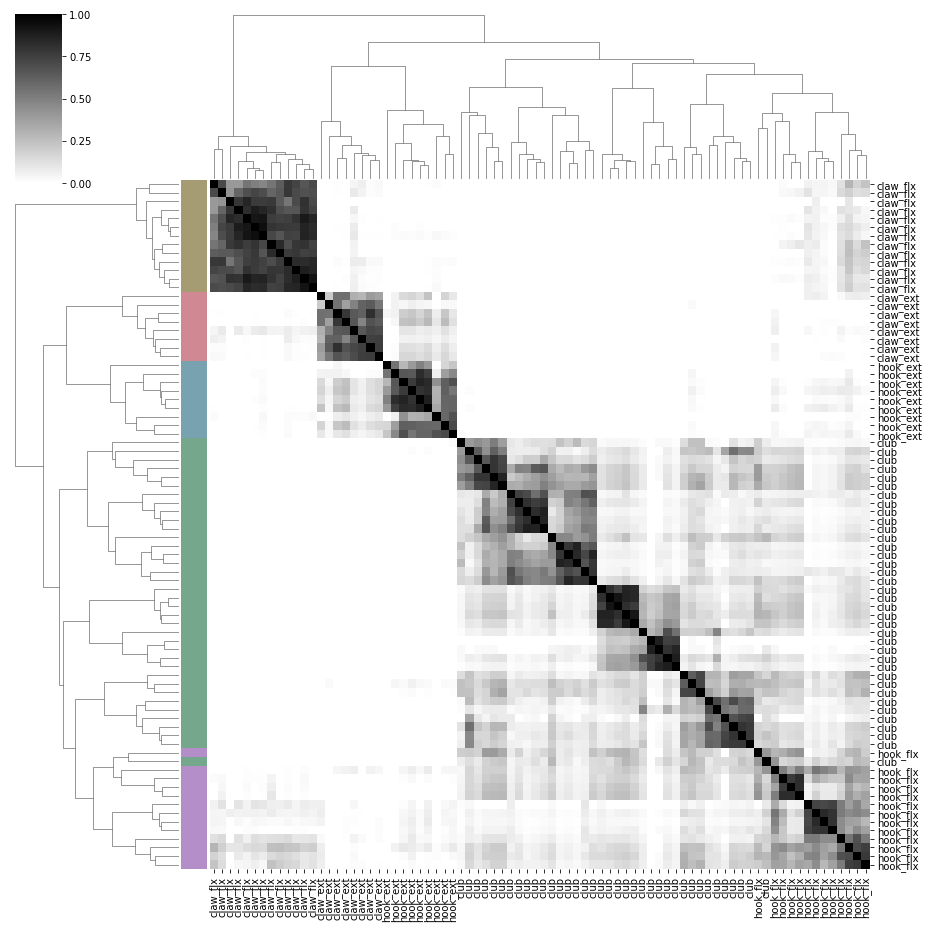

In [12]:
# Create a categorical palette to identify the networks
network_pal = sns.husl_palette(5, s=.45)
network_lut = dict(zip(np.unique(allFeCO_types_clustered), network_pal))

row_colors = [network_lut.get(item,item) for item in allFeCO_types_clustered]

clustergrid = sns.clustermap(allds_similarity_matrix, 
                      xticklabels=allFeCO_types_clustered, 
                      yticklabels=allFeCO_types_clustered, 
                      cmap=gray_map, 
                      row_colors=row_colors, 
                      figsize = [13,13])

sns.set_context("talk")
ytick_fontsize = 20
xtick_fontsize = 20

In [13]:
sort_rows = clustergrid.dendrogram_col.reordered_ind
allds_connectivity_matrix_reordered = allds_connectivity_matrix_clustered[:, sort_rows]
allFeCO_types_clustered_reordered = [allFeCO_types_clustered[i] for i in sort_rows]

max_values = np.argmax(allds_connectivity_matrix_reordered, axis=1)
sort_cols = np.argsort(max_values)

In [14]:
max_values = np.argmax(allds_connectivity_matrix_clustered, axis=1)
sort_cols = np.argsort(max_values)

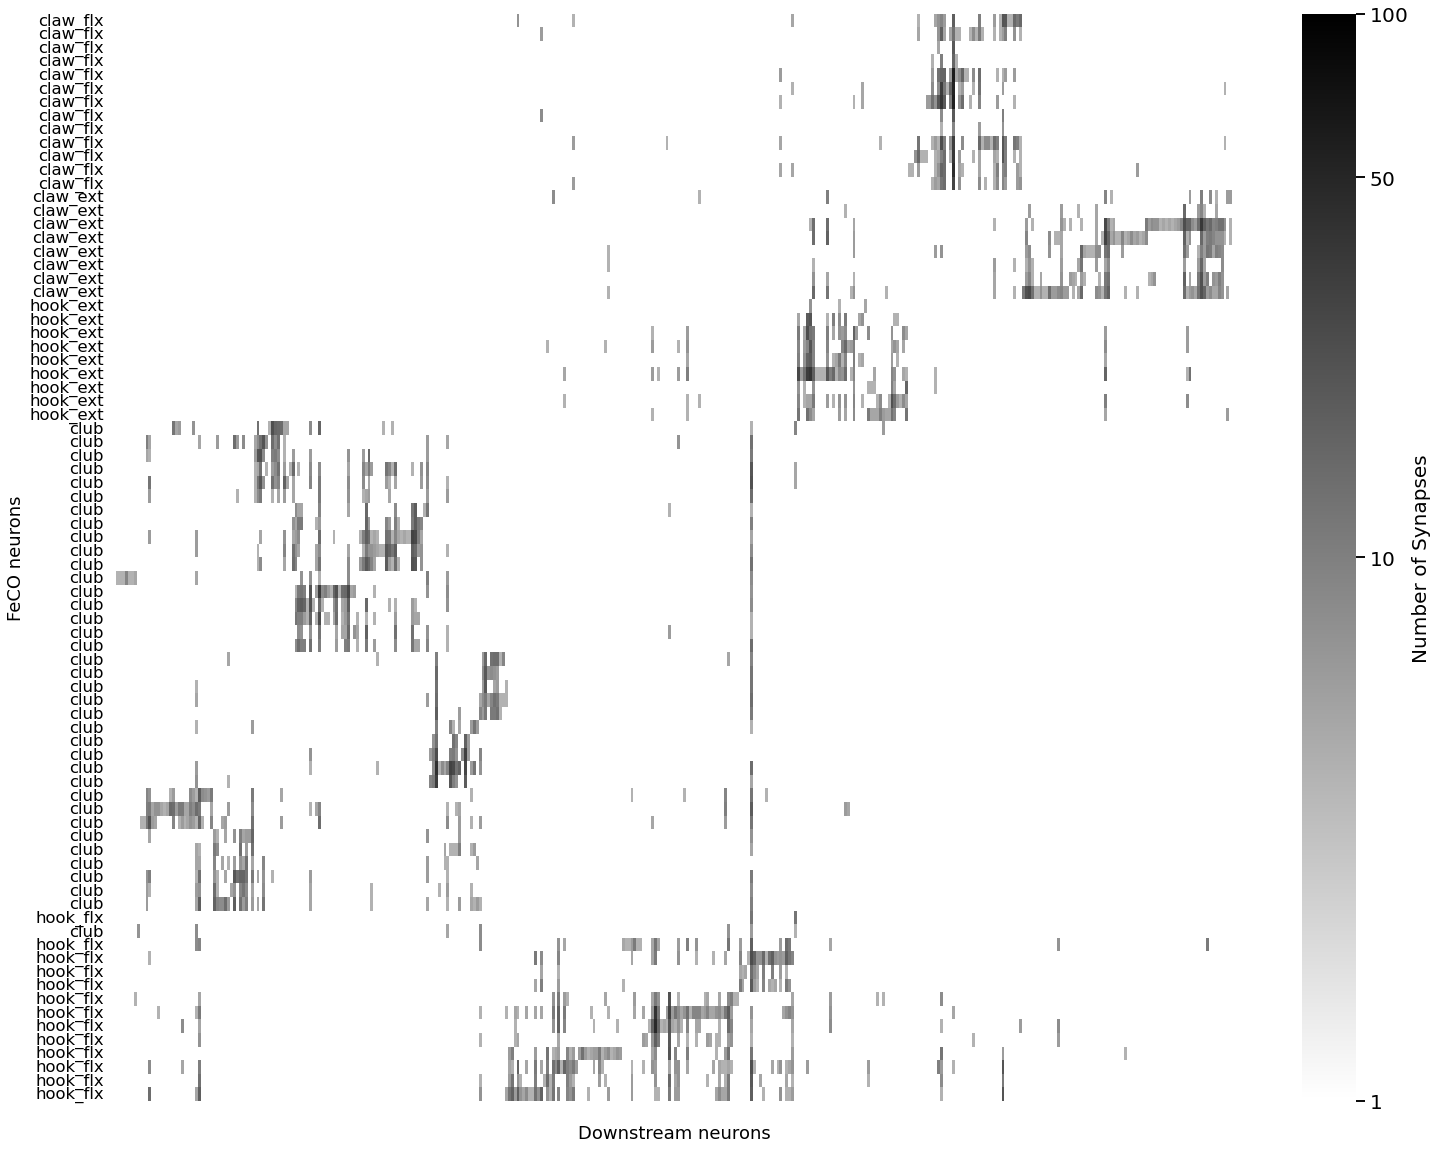

In [15]:
#plot connectivity matrix
allds_connectivity_matrix_reordered = allds_connectivity_matrix_reordered[sort_cols, :]

allds_connectivity_matrix_reordered_rotated = list(zip(*allds_connectivity_matrix_reordered[::-1]))

import matplotlib.ticker as tkr
from matplotlib import colors

figure_size = [25, 20]
fig = plt.figure(1, figsize = figure_size)
sns.set_context("talk")
ytick_fontsize = 20
xtick_fontsize = 20
cbar_ticks = [1, 10, 50, 100]
log_norm = colors.LogNorm(vmin=1, vmax=100)
formatter = tkr.ScalarFormatter(useMathText=True)
formatter.set_scientific(False)


ax = sns.heatmap(allds_connectivity_matrix_reordered_rotated, yticklabels=allFeCO_types_clustered_reordered, xticklabels=' ', 
                 cmap=gray_map, norm=log_norm, cbar_kws={"ticks": cbar_ticks, "format": formatter}, vmin = 1, vmax=100)

ax.collections[0].colorbar.ax.yaxis.set_ticks([], minor=True)
ax.set(ylabel='FeCO neurons')
ax.set(xlabel='Downstream neurons')
ax.tick_params(left=False, bottom=False)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label(label = 'Number of Synapses', size=figure_size[1])
plt.xticks(fontsize = xtick_fontsize,rotation = 90)
plt.show()